In [2]:
from Corpora import MovieReviewCorpus
from Lexicon import SentimentLexicon
from Statistics import SignTest
from Classifiers import NaiveBayesText, SVMText
from Extensions import SVMDoc2Vec
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns

In [ ]:
import os, codecs, sys
from nltk.stem.porter import PorterStemmer
from collections import defaultdict

class MovieReviewCorpus():
    def __init__(self,stemming,pos):
        """
        initialisation of movie review corpus.

        @param stemming: use porter's stemming?
        @type stemming: boolean

        @param pos: use pos tagging?
        @type pos: boolean
        """
        # raw movie reviews
        self.reviews=[]
        # held-out train/test set
        self.train=[]
        self.test=[]
        # folds for cross-validation
        self.folds={}
        # porter stemmer
        self.stemmer=PorterStemmer() if stemming else None
        # part-of-speech tags
        self.pos=pos
        # import movie reviews
        self.get_reviews()

    def get_reviews(self):
        """
        processing of movie reviews.

        1. parse reviews in data/reviews and store in self.reviews.

           the format expected for reviews is: [(string,list), ...] e.g. [("POS",["a","good","movie"]), ("NEG",["a","bad","movie"])].
           in data/reviews there are .tag and .txt files. The .txt files contain the raw reviews and .tag files contain tokenized and pos-tagged reviews.

           to save effort, we recommend you use the .tag files. you can disregard the pos tags to begin with and include them later.
           when storing the pos tags, please use the format for each review: ("POS/NEG", [(token, pos-tag), ...]) e.g. [("POS",[("a","DT"), ("good","JJ"), ...])]

           to use the stemmer the command is: self.stemmer.stem(token)

        2. store training and held-out reviews in self.train/test. files beginning with cv9 go in self.test and others in self.train

        3. store reviews in self.folds. self.folds is a dictionary with the format: self.folds[fold_number] where fold_number is an int 0-9.
           you can get the fold number from the review file name.
        """

        directory = 'data/reviews/'

        parts_list = []

        for item in os.listdir(directory):

            item_path = os.path.join(directory, item)

            if os.path.isdir(item_path):
                
                # here you are at the level of item_path being either /reviews/NEG or /reviews/POS

                label = "POS" if "POS" in item_path else "NEG"

                classified_reviews_dir = item_path

                for filename in os.listdir(classified_reviews_dir):

                    if filename.endswith(".tag"):
                        file_path = os.path.join(classified_reviews_dir, filename)

                        with codecs.open(file_path, 'r', 'utf-8') as file:

                            lines = file.readlines()

                            review_tokens = []


                            for line in lines:
                                    
                                parts = line.strip().split()

                                if len(parts) == 2:
                                    token, pos_tag = parts

                                # stem the token if stemming is enabled

                                if self.stemmer:

                                    token = self.stemmer.stem(token)

                                review_tokens.append((token, pos_tag) if self.pos else token)

                            review = (label, review_tokens)
                            self.reviews.append(review)

                        if filename.startswith('cv9'):
                            self.test.append(review)
                        
                        else:
                            self.train.append(review)
                        
                        fold_num = int(filename[2])

                        if fold_num not in self.folds:
                            self.folds[fold_num] = []

                        self.folds[fold_num].append(review)

        return self.reviews



    
"""
Notes: 
- PorterStemmer 
    - stemmers remove morphological affixes from words, leaving only the word stem (running -> run)
- POS tagging, (Parts-of-Speech) tags - represents the grammatical category of the word its attached to. 

"""


# --------------------------------------------------------------------------------------------------------------------- #

from Analysis import Evaluation
from Analysis import Evaluation

class SentimentLexicon(Evaluation):
    def __init__(self):
        """
        read in lexicon database and store in self.lexicon
        """
        # if multiple entries take last entry by default
        self.lexicon = self.get_lexicon_dict()

    def get_lexicon_dict(self):
        lexicon_dict = {}
        with open('data/sent_lexicon', 'r') as f:
            for line in f:
                word = line.split()[2].split("=")[1]
                polarity = line.split()[5].split("=")[1]
                magnitude = line.split()[0].split("=")[1]
                lexicon_dict[word] = [magnitude, polarity]
        return lexicon_dict

    def classify(self,reviews,threshold,magnitude):
        """
        classify movie reviews using self.lexicon.
        self.lexicon is a dictionary of word: [polarity_info, magnitude_info], e.g. "bad": ["negative","strongsubj"].
        explore data/sent_lexicon to get a better understanding of the sentiment lexicon.
        store the predictions in self.predictions as a list of strings where "+" and "-" are correct/incorrect classifications respectively e.g. ["+","-","+",...]

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)

        @param threshold: threshold to center decisions on. instead of using 0, there may be a bias in the reviews themselves which could be accounted for.
                          experiment for good threshold values.
        @type threshold: integer

        @type magnitude: use magnitude information from self.lexicon?
        @param magnitude: boolean
        """


        # reset predictions

        self.predictions = []


        for review_ in reviews:

            true_label = review_[0]

            vibe_checker = 0

            for word in review_[1]:

                # if word in self.lexicon and word not in stopwords.words('english'):

                if word in self.lexicon:

                    nuanced_sentiment = self.lexicon[word][0]

                    binary_sentiment = self.lexicon[word][1]

                    
                    # print(f"vibechecker before {word}: {vibe_checker}")

                    if magnitude:
                        
                        if nuanced_sentiment == 'strongsubj':
                            weight = 4
                            

                        elif nuanced_sentiment == 'weaksubj':
                            weight = 0.5
                        
                        # vibe_checker += 1*weight if binary_sentiment == 'positive' else -1*weight

                        if binary_sentiment == 'positive':
                            vibe_checker += 1 * weight
                        
                        elif binary_sentiment == 'negative':
                            vibe_checker -= 1 * weight
                        

                    else:
                        if binary_sentiment == 'positive':
                            vibe_checker += 1
                        
                        elif binary_sentiment == 'negative':
                            vibe_checker -= 1
                
                    # print(f"vibechecker after {word}: {vibe_checker}")

            if vibe_checker > threshold:
                pred_label = 'POS'

            else:
                pred_label = 'NEG'

            # print(f'true label: {true_label},  pred label: {pred_label}, vibe counter: {vibe_checker}')
            
            if true_label == pred_label:
                self.predictions.append('+')
            
            else:
                self.predictions.append('-')

    # classify2 allows for the changing of strong_weight and weak_weight ( I built this )

    def classify2(self,reviews,threshold,magnitude, strong_weight, weak_weight):
            """
            classify movie reviews using self.lexicon.
            self.lexicon is a dictionary of word: [polarity_info, magnitude_info], e.g. "bad": ["negative","strongsubj"].
            explore data/sent_lexicon to get a better understanding of the sentiment lexicon.
            store the predictions in self.predictions as a list of strings where "+" and "-" are correct/incorrect classifications respectively e.g. ["+","-","+",...]

            @param reviews: movie reviews
            @type reviews: list of (string, list) tuples corresponding to (label, content)

            @param threshold: threshold to center decisions on. instead of using 0, there may be a bias in the reviews themselves which could be accounted for.
                            experiment for good threshold values.
            @type threshold: integer

            @type magnitude: use magnitude information from self.lexicon?
            @param magnitude: boolean
            """


            # reset predictions

            self.predictions = []


            for review_ in reviews:

                true_label = review_[0]

                vibe_checker = 0

                for word in review_[1]:

                    # if word in self.lexicon and word not in stopwords.words('english'):

                    if word in self.lexicon:

                        nuanced_sentiment = self.lexicon[word][0]

                        binary_sentiment = self.lexicon[word][1]

                        
                        # print(f"vibechecker before {word}: {vibe_checker}")

                        if magnitude:
                            
                            if nuanced_sentiment == 'strongsubj':
                                weight = strong_weight
                                

                            elif nuanced_sentiment == 'weaksubj':
                                weight = weak_weight
                            
                            # vibe_checker += 1*weight if binary_sentiment == 'positive' else -1*weight

                            if binary_sentiment == 'positive':
                                vibe_checker += 1 * weight
                            
                            elif binary_sentiment == 'negative':
                                vibe_checker -= 1 * weight
                            

                        else:
                            if binary_sentiment == 'positive':
                                vibe_checker += 1
                            
                            elif binary_sentiment == 'negative':
                                vibe_checker -= 1
                    
                        # print(f"vibechecker after {word}: {vibe_checker}")

                if vibe_checker > threshold:
                    pred_label = 'POS'

                else:
                    pred_label = 'NEG'

                # print(f'true label: {true_label},  pred label: {pred_label}, vibe counter: {vibe_checker}')
                
                if true_label == pred_label:
                    self.predictions.append('+')
                
                else:
                    self.predictions.append('-')

    

In [26]:
import os
from subprocess import call
from nltk.util import ngrams
from Analysis import Evaluation
import numpy as np
from sklearn import svm
from collections import defaultdict

class NaiveBayesText(Evaluation):
    def __init__(self,smoothing,bigrams,trigrams,discard_closed_class):
        """
        initialisation of NaiveBayesText classifier.

        @param smoothing: use smoothing?
        @type smoothing: booleanp

        @param bigrams: add bigrams?
        @type bigrams: boolean

        @param trigrams: add trigrams?
        @type trigrams: boolean

        @param discard_closed_class: restrict unigrams to nouns, adjectives, adverbs and verbs?
        @type discard_closed_class: boolean
        """
        # set of features for classifier
        self.vocabulary=set()
        # prior probability
        self.prior={}
        # conditional probablility
        self.condProb={}
        # use smoothing?
        self.smoothing=smoothing
        # add bigrams?
        self.bigrams=bigrams
        # add trigrams?
        self.trigrams=trigrams
        # restrict unigrams to nouns, adjectives, adverbs and verbs?
        self.discard_closed_class=discard_closed_class
        # stored predictions from test instances
        self.predictions=[]

    def extractVocabulary(self,reviews):
        """
        extract features from training data and store in self.vocabulary.

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)
        """
        for sentiment,review in reviews:
            for token in self.extractReviewTokens(review):
                self.vocabulary.add(token)

    def extractReviewTokens(self,review):
        """
        extract tokens from reviews.

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)

        @return: list of strings
        """
        text=[]
        for token in review:
            # check if pos tags are included in review e.g. ("bad","JJ")
            if len(token)==2 and self.discard_closed_class:
                if token[1][0:2] in ["NN","JJ","RB","VB"]: text.append(token)
            else:
                text.append(token)
        if self.bigrams:
            for bigram in ngrams(review,2): text.append(bigram)
        if self.trigrams:
            for trigram in ngrams(review,3): text.append(trigram)
        return text

    def create_vocab_dict(self):
        vocab_to_id = {}
        for word in self.vocabulary:
            vocab_to_id[word] = len(vocab_to_id)
        return vocab_to_id

    def train(self,reviews):
        """
        train NaiveBayesText classifier.

        1. reset self.vocabulary, self.prior and self.condProb
        2. extract vocabulary (i.e. get features for training)
        3. get prior and conditional probability for each label ("POS","NEG") and store in self.prior and self.condProb
           note: to get conditional concatenate all text from reviews in each class and calculate token frequencies
                 to speed this up simply do one run of the movie reviews and count token frequencies if the token is in the vocabulary,
                 then iterate the vocabulary and calculate conditional probability (i.e. don't read the movie reviews in their entirety
                 each time you need to calculate a probability for each token in the vocabulary)

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)

        """


        self.vocabulary = set()
        self.prior = {}
        self.condProb = {"POS" : defaultdict(float), 
                         "NEG" : defaultdict(float)}
        
        self.extractVocabulary(reviews)

        class_counts = {"POS" : 0, "NEG" : 0}
        word_counts = {"POS" : defaultdict(int), "NEG" : defaultdict(int)}

        # Count occurences 

        for label, review in reviews:
            class_counts[label] += 1

            for token in self.extractReviewTokens(review):
                if token in self.vocabulary:
                    word_counts[label][token] += 1


        # Calculate prior probabilities

        total_reviews = len(reviews)

        for label in class_counts:
            self.prior[label] = class_counts[label] / total_reviews

        # Calculate conditional probabilities

        alpha = 1 if self.smoothing else 0 

        for label in word_counts:

            total_word_count_in_class = sum(word_counts[label].values())

            for word in self.vocabulary:

                self.condProb[label][word] = (
                    (word_counts[label][word] + alpha) / (total_word_count_in_class + alpha * len(self.vocabulary))
                )



    def test(self,reviews):
        """
        test NaiveBayesText classifier and store predictions in self.predictions.
        self.predictions should contain a "+" if prediction was correct and "-" otherwise.

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)
        """

        self.predictions = []

        i = 0

        for label, review in reviews:


            condProbReview_POS = np.log(self.prior["POS"])
            condProbReview_NEG = np.log(self.prior["NEG"])

            for token in self.extractReviewTokens(review):

                if token in self.vocabulary:
                    condProbReview_POS += np.log(self.condProb["POS"][token])
                    condProbReview_NEG+= np.log(self.condProb["NEG"][token])

            i += 1

            
            if condProbReview_POS > condProbReview_NEG:
                prediction = "POS"
            else:
                prediction = "NEG"
            
            if prediction == label:
                self.predictions.append('+')
            else:
                self.predictions.append('-')

            # print(self.predictions[:20])


class SVMText(Evaluation):
    def __init__(self,bigrams,trigrams,discard_closed_class):
        """
        initialisation of SVMText object

        @param bigrams: add bigrams?
        @type bigrams: boolean

        @param trigrams: add trigrams?
        @type trigrams: boolean

        @param svmlight_dir: location of smvlight binaries
        @type svmlight_dir: string

        @param svmlight_dir: location of smvlight binaries
        @type svmlight_dir: string

        @param discard_closed_class: restrict unigrams to nouns, adjectives, adverbs and verbs?
        @type discard_closed_class: boolean
        """
        self.svm_classifier = svm.SVC()
        self.predictions=[]
        self.vocabulary=set()
        # add in bigrams?
        self.bigrams=bigrams
        # add in trigrams?
        self.trigrams=trigrams
        # restrict to nouns, adjectives, adverbs and verbs?
        self.discard_closed_class=discard_closed_class

    def extractVocabulary(self,reviews):
        self.vocabulary = set()
        for sentiment, review in reviews:
            for token in self.extractReviewTokens(review):
                 self.vocabulary.add(token)

    def extractReviewTokens(self,review):
        """
        extract tokens from reviews.

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)

        @return: list of strings
        """
        text=[]
        for term in review:
            # check if pos tags are included in review e.g. ("bad","JJ")
            if len(term)==2 and self.discard_closed_class:
                if term[1][0:2] in ["NN","JJ","RB","VB"]: text.append(term)
            else:
                text.append(term)
        if self.bigrams:
            for bigram in ngrams(review,2): text.append(term)
        if self.trigrams:
            for trigram in ngrams(review,3): text.append(term)
        return text

    def getFeatures(self,reviews):
        """
        determine features and labels from training reviews.

        1. extract vocabulary (i.e. get features for training)
        2. extract features for each review as well as saving the sentiment
        3. append each feature to self.input_features and each label to self.labels
        (self.input_features will then be a list of list, where the inner list is
        the features)

        @param reviews: movie reviews
        @type reviews: list of (string, list) tuples corresponding to (label, content)
        """

        self.input_features = []
        self.labels = []

        # TODO Q6.

    def train(self,reviews):
        """
        train svm. This uses the sklearn SVM module, and further details can be found using
        the sci-kit docs. You can try changing the SVM parameters. 

        @param reviews: training data
        @type reviews: list of (string, list) tuples corresponding to (label, content)
        """
        # function to determine features in training set.
        self.getFeatures(reviews)

        # reset SVM classifier and train SVM model
        self.svm_classifier = svm.SVC()
        self.svm_classifier.fit(self.input_features, self.labels)

    def test(self,reviews):
        """
        test svm

        @param reviews: test data
        @type reviews: list of (string, list) tuples corresponding to (label, content)
        """

        # TODO Q6.1


In [21]:
import math,sys

class Evaluation():
    """
    general evaluation class implemented by classifiers
    """
    def crossValidate(self,corpus):
        """
        function to perform 10-fold cross-validation for a classifier.
        each classifier will be inheriting from the evaluation class so you will have access
        to the classifier's train and test functions.

        1. read reviews from corpus.folds and store 9 folds in train_files and 1 in test_files
        2. pass data to self.train and self.test e.g., self.train(train_files)
        3. repeat for another 9 runs making sure to test on a different fold each time

        @param corpus: corpus of movie reviews
        @type corpus: MovieReviewCorpus object
        """

        print("HERE")
        # reset predictions
        self.predictions=[]

        splits = {}

        print("corpus folds[0][0]", corpus.folds[0][0])

        for list_review_fold in corpus.folds:
            for i in range(len(list_review_fold)):
                print("here")
                splits[i] = list_review_fold[i]


        print(splits.keys())
        

        

        # "Report results using 10-fold Round-Robin cross-validation"






        # TODO Q3

    def getStdDeviation(self):
        """
        get standard deviation across folds in cross-validation.
        """
        # get the avg accuracy and initialize square deviations
        avgAccuracy,square_deviations=self.getAccuracy(),0
        # find the number of instances in each fold
        fold_size=len(self.predictions)//10
        # calculate the sum of the square deviations from mean
        for fold in range(0,len(self.predictions),fold_size):
            square_deviations+=(self.predictions[fold:fold+fold_size].count("+")/float(fold_size) - avgAccuracy)**2
        # std deviation is the square root of the variance (mean of square deviations)
        return math.sqrt(square_deviations/10.0)

    def getAccuracy(self):
        """
        get accuracy of classifier.

        @return: float containing percentage correct
        """
        # note: data set is balanced so just taking number of correctly classified over total
        # "+" = correctly classified and "-" = error
        return self.predictions.count("+")/float(len(self.predictions))


In [6]:
corpus=MovieReviewCorpus(stemming=False,pos=False)
test = corpus.get_reviews()

In [7]:
# retrieve corpus
corpus=MovieReviewCorpus(stemming=False,pos=False)

# use sign test for all significance testing
signTest=SignTest()

print("--- classifying reviews using sentiment lexicon  ---")

# read in lexicon
lexicon=SentimentLexicon()

# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
threshold=8

# question 0.1
lexicon.classify(corpus.reviews, threshold, magnitude=False)
token_preds=lexicon.predictions
# print(token_preds)
print(f"token-only results: {lexicon.getAccuracy():.2f}")

lexicon.classify(corpus.reviews,threshold,magnitude=True)
magnitude_preds=lexicon.predictions
print(f"magnitude results:{lexicon.getAccuracy():.2f}")

# question 0.2
p_value=signTest.getSignificance(token_preds,magnitude_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"magnitude lexicon results are {significance} with respect to token-only")

--- classifying reviews using sentiment lexicon  ---
token-only results: 0.68
magnitude results:0.69
magnitude lexicon results are not significant with respect to token-only


In [9]:
# produce a plot to test the accuracy of different weight parameters, with and without stopwords

strong_weight_list = [1, 2, 3, 4, 5, 7]
weak_weight_list = [1, 0.75, 0.5, 0.25, 0.1, 0.05]

dim1 = len(strong_weight_list)
dim2 = len(weak_weight_list)

accuracy_array = np.zeros((dim1, dim2))
print(accuracy_array.shape)

for i_s, strong in enumerate(strong_weight_list):
    for i_w, weak in enumerate(weak_weight_list):

        lexicon.classify2(corpus.reviews, threshold, magnitude=True, strong_weight=strong, weak_weight=weak)
        token_preds=lexicon.predictions
        accuracy = lexicon.getAccuracy()
        print(f"token-only results: {lexicon.getAccuracy():.2f}")

        accuracy_array[i_s, i_w] = accuracy


print(accuracy_array)



(6, 6)
token-only results: 0.68
token-only results: 0.68
token-only results: 0.69
token-only results: 0.67
token-only results: 0.67
token-only results: 0.67
token-only results: 0.68
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.68
token-only results: 0.68
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.68
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.68
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
token-only results: 0.68
token-only results: 0.68
token-only results: 0.68
token-only results: 0.69
token-only results: 0.69
token-only results: 0.69
[[0.6795 0.6835 0.687  0.6745 0.6715 0.667 ]
 [0.6815 0.6875 0.6885 0.6855 0.682  0.682 ]
 [0

<AxesSubplot:>

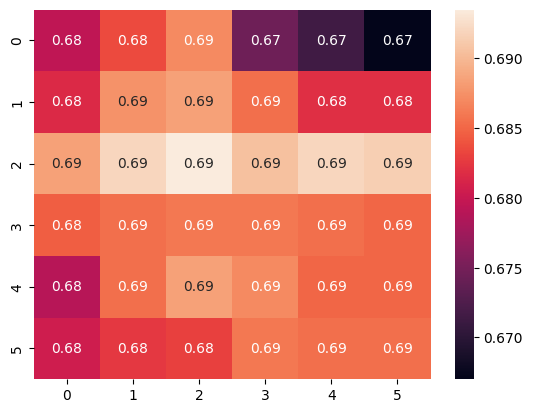

In [10]:
sns.heatmap(accuracy_array, annot = True)

# you have to test different thresholds as well

In [23]:
# retrieve corpus
corpus=MovieReviewCorpus(stemming=False,pos=True)

# use sign test for all significance testing
signTest=SignTest()

print("--- classifying reviews using sentiment lexicon  ---")

# read in lexicon
lexicon=SentimentLexicon()

# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
threshold=8

# question 0.1
lexicon.classify(corpus.reviews, threshold, magnitude=False)

--- classifying reviews using sentiment lexicon  ---


In [1]:
test = corpus.reviews



NameError: name 'corpus' is not defined

In [11]:
# question 1.0
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test)
# store predictions from classifier
non_smoothed_preds=NB.predictions
print(f"Accuracy without smoothing: {NB.getAccuracy():.2f}")

--- classifying reviews using Naive Bayes on held-out test set ---
Accuracy without smoothing: 0.51


/home/sofia/miniconda3/envs/MLMI_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in log
/home/sofia/miniconda3/envs/MLMI_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: divide by zero encountered in log


In [12]:
# question 2.0
# use smoothing
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test)
smoothed_preds=NB.predictions
# saving this for use later
num_non_stemmed_features=len(NB.vocabulary)
print(f"Accuracy using smoothing: {NB.getAccuracy():.2f}")

# Filip "right now we run bigram and unigram together but if you run just bigram you recieve higher performance"


# question 2.1
# see if smoothing significantly improves results
p_value=signTest.getSignificance(non_smoothed_preds,smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"Results using smoothing are {significance} with respect to no smoothing")

Accuracy using smoothing: 0.83
Results using smoothing are significant with respect to no smoothing


In [ ]:
# question 3.0
print("--- classifying reviews using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus)
print("finished")


# there is a big error somewhere stemming from the fact that Evaluation is defined in Analysis.py but I have also defined it in the jupyter notebook. 
# to do - integrate the functions





# using cross-eval for smoothed predictions from now on
# smoothed_preds=NB.predictions
# print(f"Accuracy: {NB.getAccuracy():.3f}")
# print(f"Std. Dev: {NB.getStdDeviation()}")

--- classifying reviews using 10-fold cross-evaluation ---
finished


In [8]:
index_list = np.arange(0, 10)

for index in index_list:
    test_index = index
    
    training_index_list = np.delete(index_list, index)
    print(f'training: {training_index_list}, test: {test_index}')



training: [1 2 3 4 5 6 7 8 9], test: 0
training: [0 2 3 4 5 6 7 8 9], test: 1
training: [0 1 3 4 5 6 7 8 9], test: 2
training: [0 1 2 4 5 6 7 8 9], test: 3
training: [0 1 2 3 5 6 7 8 9], test: 4
training: [0 1 2 3 4 6 7 8 9], test: 5
training: [0 1 2 3 4 5 7 8 9], test: 6
training: [0 1 2 3 4 5 6 8 9], test: 7
training: [0 1 2 3 4 5 6 7 9], test: 8
training: [0 1 2 3 4 5 6 7 8], test: 9


In [ ]:
# question 4.0
print("--- stemming corpus ---")
# retrieve corpus with tokenized text and stemming (using porter)
stemmed_corpus=MovieReviewCorpus(stemming=True,pos=False)
print("--- cross-validating NB using stemming ---")
NB.crossValidate(stemmed_corpus)
stemmed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.3f}")
print(f"Std. Dev: {NB.getStdDeviation():.3f}")

# TODO Q4.1
# see if stemming significantly improves results on smoothed NB

# TODO Q4.2
print("--- determining the number of features before/after stemming ---")

In [ ]:
# question Q5.0
# cross-validate model using smoothing and bigrams
print("--- cross-validating naive bayes using smoothing and bigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False)
NB.crossValidate(corpus)
smoothed_and_bigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.2f}") 
print(f"Std. Dev: {NB.getStdDeviation():.2f}")


# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_bigram_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams are {signifance} with respect to smoothing only")


# TODO Q5.1

In [ ]:
# TODO Q6 and 6.1
print("--- classifying reviews using SVM 10-fold cross-eval ---")

In [ ]:
# TODO Q7
print("--- adding in POS information to corpus ---")
print("--- training svm on word+pos features ----")
print("--- training svm discarding closed-class words ---")

In [ ]:
# question 8.0
print("--- using document embeddings ---")